<a href="https://colab.research.google.com/github/CJPJ007/Text-Classifcation/blob/master/Janatahack_Independence_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import re
import nltk
import warnings
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds 
from google.colab import drive

In [3]:
train=pd.read_csv("/content/drive/My Drive/Data/Janatahack Independence Day/train.csv")

In [4]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
train['TITLE']=train['TITLE'].str.lower()
train['ABSTRACT']=train['ABSTRACT'].str.lower()

In [6]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,reconstructing subject-specific effect maps,predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,rotation invariance neural network,rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,spherical polyharmonics and poisson kernels fo...,we introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,a finite element approximation for the stochas...,the stochastic landau--lifshitz--gilbert (ll...,0,0,1,0,0,0
4,5,comparative study of discrete wavelet transfor...,fourier-transform infra-red (ftir) spectra o...,1,0,0,1,0,0


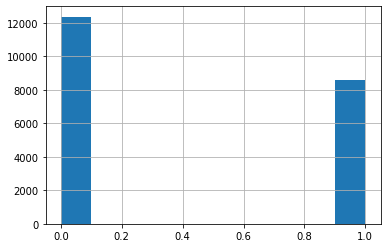

In [7]:
train['Computer Science'].hist()

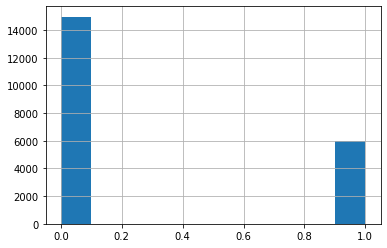

In [8]:
train['Physics'].hist()

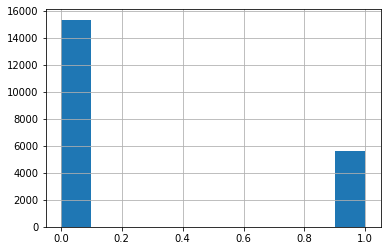

In [9]:
train['Mathematics'].hist()

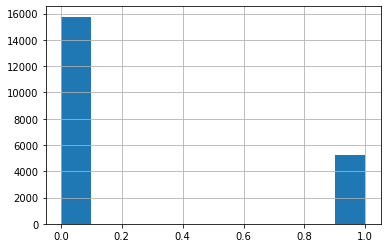

In [10]:
train['Statistics'].hist()

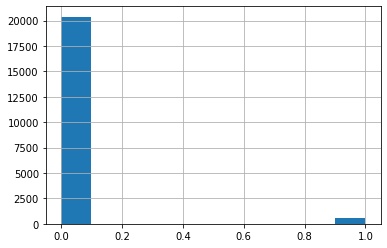

In [11]:
train['Quantitative Biology'].hist()

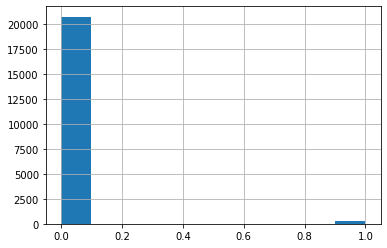

In [12]:
train['Quantitative Finance'].hist()

In [13]:
def clean_text(text):
  text=BeautifulSoup(text,'lxml').get_text()
  text=re.sub(r"@[a-zA-z0-9]+"," ",text)
  text=re.sub(r"https?://[a-zA-Z0-9./]+"," ",text)
  text=re.sub(r"[^a-zA-Z]"," ",text)
  text=re.sub(r" +"," ",text)
  return text

In [14]:
train['TITLE']=train['TITLE'].apply(lambda x : clean_text(x))
train['ABSTRACT']=train['ABSTRACT'].apply(lambda x : clean_text(x))

In [15]:
train['TEXT']=train['TITLE']+train['ABSTRACT']
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TEXT
0,1,reconstructing subject specific effect maps,predictive models allow subject specific infer...,1,0,0,0,0,0,reconstructing subject specific effect mapspre...
1,2,rotation invariance neural network,rotation invariance and translation invariance...,1,0,0,0,0,0,rotation invariance neural networkrotation inv...
2,3,spherical polyharmonics and poisson kernels fo...,we introduce and develop the notion of spheric...,0,0,1,0,0,0,spherical polyharmonics and poisson kernels fo...
3,4,a finite element approximation for the stochas...,the stochastic landau lifshitz gilbert llg equ...,0,0,1,0,0,0,a finite element approximation for the stochas...
4,5,comparative study of discrete wavelet transfor...,fourier transform infra red ftir spectra of sa...,1,0,0,1,0,0,comparative study of discrete wavelet transfor...


In [16]:
tokenizer=tfds.features.text.SubwordTextEncoder.build_from_corpus(
    train['TEXT'],
    2**16
)
data=[tokenizer.encode(sentence) for sentence in train['TEXT']]

In [17]:
MAX_LEN=max([len(sentence) for sentence in data])
data=tf.keras.preprocessing.sequence.pad_sequences(
    data,
    value=0,
    padding='post',
    maxlen=MAX_LEN
) 
data_labels=train['Computer Science'].values

In [18]:
from sklearn.model_selection import train_test_split
(X_train,X_test,Y_train,Y_test)=train_test_split(data,data_labels,
                                                 test_size=0.2,
                                                 random_state=1)
(X_test,X_val,Y_test,Y_val)=train_test_split(X_test,Y_test
                                             ,test_size=0.5
                                             ,random_state=1)

In [19]:
class DCNN(tf.keras.Model):
  def __init__(self
               ,vocab_size
               ,emb_dim=128
               ,nb_filters=50
               ,FFN_units=512
               ,nb_classes=2
               ,dropout_rate=0.1
               ,training=False
               ,name='dcnn'):
    super(DCNN,self).__init__(name=name)

    self.embedding=layers.Embedding(vocab_size,emb_dim)

    self.bigram=layers.Conv1D(filters=nb_filters
                              ,kernel_size=2
                              ,padding="valid"
                              ,activation='relu')
    self.pool_1=layers.GlobalMaxPool1D()
    self.trigram=layers.Conv1D(filters=nb_filters
                              ,kernel_size=3
                              ,padding="valid"
                              ,activation='relu')
    self.pool_2=layers.GlobalMaxPool1D()
    self.fourgram=layers.Conv1D(filters=nb_filters
                              ,kernel_size=4
                              ,padding="valid"
                              ,activation='relu')
    self.pool_3=layers.GlobalMaxPool1D()
    self.dense_1=layers.Dense(units=FFN_units,activation='relu')
    self.dropout=layers.Dropout(rate=dropout_rate)
    if nb_classes==2:
      self.last_dense=layers.Dense(1,activation='sigmoid')
    else:
      self.last_dense=layers.Dense(nb_classes,activation='softmax')

  def call(self,inputs,training):
    x=self.embedding(inputs)
    x_1=self.bigram(x)
    x_1=self.pool_1(x_1)
    x_2=self.trigram(x)
    x_2=self.pool_2(x_2)
    x_3=self.fourgram(x)
    x_3=self.pool_3(x_3)

    merged=tf.concat([x_1,x_2,x_3],axis=-1)
    merged=self.dense_1(merged)
    merged=self.dropout(merged,training)
    output=self.last_dense(merged)

    return output 


In [20]:
VOCAB_SIZE=tokenizer.vocab_size

EMB_DIM=200
NB_FILTERS=100
NB_CLASSES=len(set(data_labels))
FFN_UNITS=128

DROPOUT_RATE=0.5

NB_EPOCHS=5
BATCH_SIZE=64

In [21]:
dcnn=DCNN(vocab_size=VOCAB_SIZE,
          FFN_units=FFN_UNITS,
          nb_filters=NB_FILTERS,
          nb_classes=NB_CLASSES,
          dropout_rate=DROPOUT_RATE,
          emb_dim=EMB_DIM)

In [22]:
dcnn.compile(optimizer='adam',loss='binary_crossentropy',
               metrics=['accuracy'])

In [23]:
dcnn.fit(X_train,Y_train,epochs=NB_EPOCHS,batch_size=BATCH_SIZE,
         validation_data=(X_val,Y_val))

Epoch 1/5
263/263 [==============================] - 35s 135ms/step - loss: 0.4309 - accuracy: 0.7927 - val_loss: 0.3077 - val_accuracy: 0.8661
Epoch 2/5
263/263 [==============================] - 36s 135ms/step - loss: 0.2348 - accuracy: 0.9073 - val_loss: 0.2981 - val_accuracy: 0.8732
Epoch 3/5
263/263 [==============================] - 36s 135ms/step - loss: 0.0939 - accuracy: 0.9695 - val_loss: 0.3798 - val_accuracy: 0.8627
Epoch 4/5
263/263 [==============================] - 35s 134ms/step - loss: 0.0167 - accuracy: 0.9965 - val_loss: 0.4996 - val_accuracy: 0.8561
Epoch 5/5
263/263 [==============================] - 35s 134ms/step - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.5898 - val_accuracy: 0.8594


In [24]:
dcnn.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

33/33 [==============================] - 0s 10ms/step - loss: 0.6085 - accuracy: 0.8560


[0.6084951758384705, 0.8559847474098206]

In [25]:
dcnn_2=DCNN(vocab_size=VOCAB_SIZE,
          FFN_units=FFN_UNITS,
          nb_filters=NB_FILTERS,
          nb_classes=NB_CLASSES,
          dropout_rate=DROPOUT_RATE,
          emb_dim=EMB_DIM)

In [26]:
dcnn_2.compile(optimizer='adam',loss='binary_crossentropy',
               metrics=['accuracy'])

In [27]:
data_labels=train['Physics'].values
(X_train,X_test,Y_train,Y_test)=train_test_split(data,data_labels,
                                                 test_size=0.2,
                                                 random_state=1)
(X_test,X_val,Y_test,Y_val)=train_test_split(X_test,Y_test
                                             ,test_size=0.5
                                             ,random_state=1)

In [28]:
dcnn_2.fit(X_train,Y_train,epochs=NB_EPOCHS,batch_size=BATCH_SIZE,
         validation_data=(X_val,Y_val))

Epoch 1/5
263/263 [==============================] - 34s 129ms/step - loss: 0.3109 - accuracy: 0.8665 - val_loss: 0.1724 - val_accuracy: 0.9342
Epoch 2/5
263/263 [==============================] - 34s 129ms/step - loss: 0.1081 - accuracy: 0.9604 - val_loss: 0.1732 - val_accuracy: 0.9290
Epoch 3/5
263/263 [==============================] - 34s 129ms/step - loss: 0.0284 - accuracy: 0.9920 - val_loss: 0.2157 - val_accuracy: 0.9318
Epoch 4/5
263/263 [==============================] - 34s 128ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.2624 - val_accuracy: 0.9366
Epoch 5/5
263/263 [==============================] - 34s 129ms/step - loss: 9.1625e-04 - accuracy: 1.0000 - val_loss: 0.2925 - val_accuracy: 0.9337


In [29]:
dcnn_2.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

33/33 [==============================] - 0s 9ms/step - loss: 0.3152 - accuracy: 0.9294


[0.3151969909667969, 0.9294229745864868]

In [30]:
dcnn_3=DCNN(vocab_size=VOCAB_SIZE,
          FFN_units=FFN_UNITS,
          nb_filters=NB_FILTERS,
          nb_classes=NB_CLASSES,
          dropout_rate=DROPOUT_RATE,
          emb_dim=EMB_DIM)

dcnn_3.compile(optimizer='adam',loss='binary_crossentropy',
               metrics=['accuracy'])

data_labels=train['Mathematics'].values
(X_train,X_test,Y_train,Y_test)=train_test_split(data,data_labels,
                                                 test_size=0.2,
                                                 random_state=1)
(X_test,X_val,Y_test,Y_val)=train_test_split(X_test,Y_test
                                             ,test_size=0.5
                                             ,random_state=1)

dcnn_3.fit(X_train,Y_train,epochs=NB_EPOCHS,batch_size=BATCH_SIZE,
         validation_data=(X_val,Y_val))

Epoch 1/5
263/263 [==============================] - 36s 136ms/step - loss: 0.3483 - accuracy: 0.8447 - val_loss: 0.2193 - val_accuracy: 0.9104
Epoch 2/5
263/263 [==============================] - 36s 135ms/step - loss: 0.1683 - accuracy: 0.9354 - val_loss: 0.2226 - val_accuracy: 0.9123
Epoch 3/5
263/263 [==============================] - 36s 135ms/step - loss: 0.0659 - accuracy: 0.9777 - val_loss: 0.2648 - val_accuracy: 0.9104
Epoch 4/5
263/263 [==============================] - 35s 135ms/step - loss: 0.0117 - accuracy: 0.9977 - val_loss: 0.3813 - val_accuracy: 0.8999
Epoch 5/5
263/263 [==============================] - 36s 136ms/step - loss: 0.0020 - accuracy: 0.9999 - val_loss: 0.4197 - val_accuracy: 0.9047


In [31]:
dcnn_3.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

33/33 [==============================] - 0s 9ms/step - loss: 0.4746 - accuracy: 0.8913


[0.4746202826499939, 0.8912732601165771]

In [32]:
dcnn_4=DCNN(vocab_size=VOCAB_SIZE,
          FFN_units=FFN_UNITS,
          nb_filters=NB_FILTERS,
          nb_classes=NB_CLASSES,
          dropout_rate=DROPOUT_RATE,
          emb_dim=EMB_DIM)

dcnn_4.compile(optimizer='adam',loss='binary_crossentropy',
               metrics=['accuracy'])

data_labels=train['Statistics'].values
(X_train,X_test,Y_train,Y_test)=train_test_split(data,data_labels,
                                                 test_size=0.2,
                                                 random_state=1)
(X_test,X_val,Y_test,Y_val)=train_test_split(X_test,Y_test
                                             ,test_size=0.5
                                             ,random_state=1)

dcnn_4.fit(X_train,Y_train,epochs=NB_EPOCHS,batch_size=BATCH_SIZE,
         validation_data=(X_val,Y_val))

Epoch 1/5
263/263 [==============================] - 36s 138ms/step - loss: 0.3739 - accuracy: 0.8291 - val_loss: 0.2512 - val_accuracy: 0.8880
Epoch 2/5
263/263 [==============================] - 36s 138ms/step - loss: 0.1991 - accuracy: 0.9189 - val_loss: 0.2573 - val_accuracy: 0.8842
Epoch 3/5
263/263 [==============================] - 36s 137ms/step - loss: 0.0899 - accuracy: 0.9700 - val_loss: 0.2850 - val_accuracy: 0.8870
Epoch 4/5
263/263 [==============================] - 36s 138ms/step - loss: 0.0230 - accuracy: 0.9950 - val_loss: 0.3972 - val_accuracy: 0.8823
Epoch 5/5
263/263 [==============================] - 36s 138ms/step - loss: 0.0050 - accuracy: 0.9993 - val_loss: 0.4657 - val_accuracy: 0.8770


In [33]:
dcnn_4.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

33/33 [==============================] - 0s 10ms/step - loss: 0.5033 - accuracy: 0.8798


[0.5032674074172974, 0.8798283338546753]

In [34]:
from imblearn.over_sampling import ADASYN
over=ADASYN()
dcnn_5=DCNN(vocab_size=VOCAB_SIZE,
          FFN_units=FFN_UNITS,
          nb_filters=NB_FILTERS,
          nb_classes=NB_CLASSES,
          dropout_rate=DROPOUT_RATE,
          emb_dim=EMB_DIM)

dcnn_5.compile(optimizer='adam',loss='binary_crossentropy',
               metrics=['accuracy'])

data_labels=train['Quantitative Biology'].values
x,y=over.fit_sample(data,data_labels)
(X_train,X_test,Y_train,Y_test)=train_test_split(x,y,
                                                 test_size=0.2,
                                                 random_state=1)
(X_test,X_val,Y_test,Y_val)=train_test_split(X_test,Y_test
                                             ,test_size=0.5
                                             ,random_state=1)

dcnn_5.fit(X_train,Y_train,epochs=NB_EPOCHS,batch_size=BATCH_SIZE,
         validation_data=(X_val,Y_val))

Epoch 1/5
508/508 [==============================] - 69s 136ms/step - loss: 0.1153 - accuracy: 0.9625 - val_loss: 0.0539 - val_accuracy: 0.9835
Epoch 2/5
508/508 [==============================] - 69s 135ms/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0539 - val_accuracy: 0.9852
Epoch 3/5
508/508 [==============================] - 69s 135ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.1058 - val_accuracy: 0.9825
Epoch 4/5
508/508 [==============================] - 69s 135ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0782 - val_accuracy: 0.9850
Epoch 5/5
508/508 [==============================] - 69s 136ms/step - loss: 2.5824e-04 - accuracy: 1.0000 - val_loss: 0.0866 - val_accuracy: 0.9857


In [35]:
dcnn_5.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

64/64 [==============================] - 1s 9ms/step - loss: 0.0723 - accuracy: 0.9867


[0.07225962728261948, 0.9866962432861328]

In [36]:
over_2=ADASYN()
dcnn_6=DCNN(vocab_size=VOCAB_SIZE,
          FFN_units=FFN_UNITS,
          nb_filters=NB_FILTERS,
          nb_classes=NB_CLASSES,
          dropout_rate=DROPOUT_RATE,
          emb_dim=EMB_DIM)

dcnn_6.compile(optimizer='adam',loss='binary_crossentropy',
               metrics=['accuracy'])

data_labels=train['Quantitative Finance'].values
x,y=over_2.fit_sample(data,data_labels)
(X_train,X_test,Y_train,Y_test)=train_test_split(x,y,
                                                 test_size=0.2,
                                                 random_state=1)
(X_test,X_val,Y_test,Y_val)=train_test_split(X_test,Y_test
                                             ,test_size=0.5
                                             ,random_state=1)

dcnn_6.fit(X_train,Y_train,epochs=NB_EPOCHS,batch_size=BATCH_SIZE,
         validation_data=(X_val,Y_val))

Epoch 1/5
519/519 [==============================] - 68s 131ms/step - loss: 0.0889 - accuracy: 0.9684 - val_loss: 0.0270 - val_accuracy: 0.9945
Epoch 2/5
519/519 [==============================] - 68s 131ms/step - loss: 0.0129 - accuracy: 0.9967 - val_loss: 0.0254 - val_accuracy: 0.9940
Epoch 3/5
519/519 [==============================] - 68s 130ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0313 - val_accuracy: 0.9945
Epoch 4/5
519/519 [==============================] - 68s 131ms/step - loss: 9.4928e-04 - accuracy: 0.9998 - val_loss: 0.0432 - val_accuracy: 0.9928
Epoch 5/5
519/519 [==============================] - 68s 131ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0378 - val_accuracy: 0.9947


In [37]:
dcnn_6.evaluate(X_test,Y_test,batch_size=BATCH_SIZE)

65/65 [==============================] - 1s 9ms/step - loss: 0.0351 - accuracy: 0.9940


[0.03512975946068764, 0.9939715266227722]

In [38]:
test=pd.read_csv('/content/drive/My Drive/Data/Janatahack Independence Day/test.csv')
test['TITLE']=test['TITLE'].apply(lambda x : clean_text(x))
test['ABSTRACT']=test['ABSTRACT'].apply(lambda x : clean_text(x))
test['TEXT']=test['TITLE']+test['ABSTRACT']

In [39]:
testing_data=[tokenizer.encode(testing) for testing in test['TEXT']]
testing_data=tf.keras.preprocessing.sequence.pad_sequences(
    testing_data,
    value=0,
    padding='post',
    maxlen=MAX_LEN
)

In [43]:
test['Computer Science']=np.round(dcnn.predict(testing_data)>=0.5)
test['Physics']=np.round(dcnn_2.predict(testing_data)>=0.5)
test['Mathematics']=np.round(dcnn_3.predict(testing_data)>=0.5)
test['Statistics']=np.round(dcnn_4.predict(testing_data)>=0.5)
test['Quantitative Biology']=np.round(dcnn_5.predict(testing_data)>=0.5)
test['Quatitative Finance']=np.round(dcnn_6.predict(testing_data)>=0.5)

In [44]:
sub=test[['ID','Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quatitative Finance']]
sub.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quatitative Finance
0,20973,0.0,0.0,0.0,1.0,0.0,0.0
1,20974,0.0,1.0,0.0,0.0,0.0,0.0
2,20975,1.0,0.0,0.0,0.0,0.0,0.0
3,20976,0.0,1.0,0.0,0.0,0.0,0.0
4,20977,1.0,0.0,0.0,0.0,0.0,0.0


In [45]:
sub.to_csv('Submission.csv',index=False)